In [1]:
import tensorflow as tf
import utils as u
import h5py
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import os
import numpy as np
import random as rn


from sklearn.metrics import roc_curve,roc_auc_score,auc
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn import metrics

%matplotlib inline
import itertools

import keras 
from keras.models import load_model
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras import backend as K
from keras.layers import Dense, Dropout, Flatten,Conv2D, MaxPooling2D,Activation,BatchNormalization,LeakyReLU
from keras.utils import to_categorical,plot_model
from keras.models import Sequential
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
#for reproducibility in Python,numpy and Tensorflow we set their respective seeds as follows
os.environ['PYTHONHASHSEED']='0'
np.random.seed(None) ##don't want to seed numpy with randomly placed or sized hot/dead regions
rn.seed(2)
tf.set_random_seed(3)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

#Force Tensorflow to use a single thread (this is recommended because it might be a cause of randomness)
sess=tf.Session(graph=tf.get_default_graph(),config=session_conf)
K.set_session(sess)

In [25]:
data_folder = '../../data'
file_name = 'HCAL_digi+rechit_occ_run306138.hdf5'
group = 'DigiTask_Occupancy_depth_depth1'

input_file=h5py.File(data_folder+"/"+file_name,'r+')

data_sample= np.array(input_file[group])


print data_sample.shape

data_sample=data_sample[:,:,26:58]

print data_sample.shape

(999, 72, 84)
(999, 72, 32)


Average value of good image is: 567.19
Shape of regular image is:  (999, 72, 32)
Shape of dead image is:  (999, 72, 32)
Shape of hot image is:  (999, 72, 32)



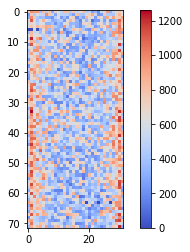

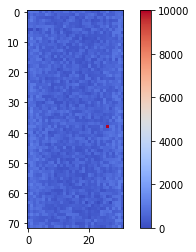

In [26]:
input_images=data_sample[:]
hotregion_image=[]
deadregion_image=[]

for k in input_images:
    xLen = 1 #np.random.randint(1,17)
    yLen = 1 #np.random.randint(1,17)
    
    a=np.random.randint(input_images.shape[2]-xLen)
    b=np.random.randint(input_images.shape[1]-yLen)
    
    xdim=(a,a+xLen)
    ydim=(b,b+yLen)
    
    #print 'xdim =', xdim
    #print 'ydim =', ydim
   
    hotregion_image.append( u.hotregion(k,xdim,ydim))
    deadregion_image.append(u.killregion(k,xdim,ydim))

print 'Average value of good image is:', np.average(input_images)
    
hotregion_image=np.array(hotregion_image)
deadregion_image=np.array(deadregion_image)

print "Shape of regular image is: ",input_images.shape
print "Shape of dead image is: " ,deadregion_image.shape
print "Shape of hot image is: " ,hotregion_image.shape

print ''
im=plt.imshow(input_images[1],cmap=cm.coolwarm)
plt.colorbar()
plt.show()
plt.clf()


im=plt.imshow(hotregion_image[1],cmap=cm.coolwarm)
plt.colorbar()
plt.show()
plt.clf()#plt.clf clears the figure and it's axis but leaves the window open. 
         #as opposed to plt.close which closes the window. If you are showing many images at a time without
         #closing the window it is better.


In [5]:
sample= np.append(data_sample,hotregion_image,axis=0)
sample= np.append(sample,deadregion_image,axis=0)
print sample.shape
X=np.copy(sample)

y=np.zeros((sample.shape[0],1))
k=0
for img in X:
    X[k] = X[k] / np.max(img)
    k=k+1
#print y.shape
#print input_images.shape[0]


#this is because I am only going to add the hot and dead region images

### Changed this to a 2 class problem, good and bad
y[-2*input_images.shape[0]:]=1

#if you want it as integers leave this as it is
#if you would like it as a vector then do this
y=to_categorical(y,2)

# convert class vectors to binary class matrices
#y_train = keras.utils.to_categorical(y_train, num_classes)
#y_test = keras.utils.to_categorical(y_test, num_classes)

print "X shape is: ",X.shape
print "y shape is: ",y.shape
# input image dimensions
img_rows, img_cols = X.shape[1],X.shape[2]

(2997, 72, 32)
X shape is:  (2997, 72, 32)
y shape is:  (2997, 2)


Xtrain.shape (1798, 72, 32)
Xtest.shape (1199, 72, 32)
ytrain.shape (1798, 2)
ytest.shape (1199, 2)
Printing labels and their corresponding images
-------------------
[ 0.  1.]


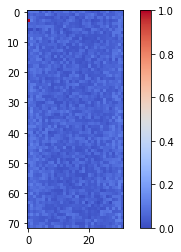

-------------------
[ 0.  1.]


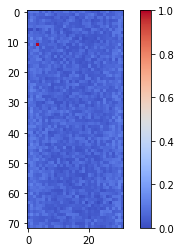

-------------------
[ 1.  0.]


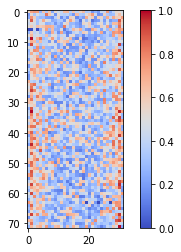

-------------------
[ 0.  1.]


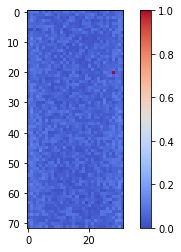

-------------------
[ 1.  0.]


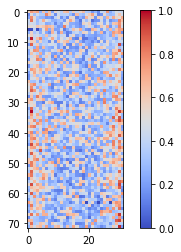

-------------------
[ 1.  0.]


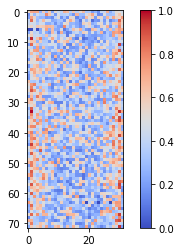

-------------------
[ 1.  0.]


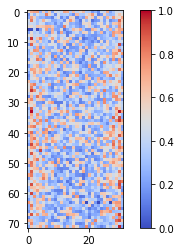

-------------------
[ 0.  1.]


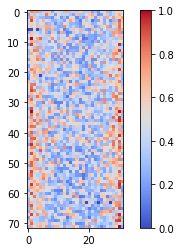

-------------------
[ 0.  1.]


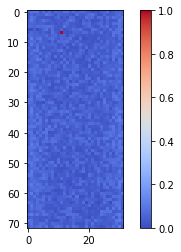

-------------------
[ 0.  1.]


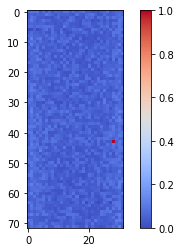

Xtrain.shape after if statement (1798, 72, 32, 1)
Xtest.shape after if statement (1199, 72, 32, 1)
ytrain.shape after if statement (1798, 2)
ytest.shape after if statement (1199, 2)


In [6]:
Xtrain, Xtest ,ytrain, ytest =train_test_split(X,y,test_size=.4,random_state =5 )

print 'Xtrain.shape',Xtrain.shape
print 'Xtest.shape',Xtest.shape
print 'ytrain.shape',ytrain.shape
print 'ytest.shape',ytest.shape
print 'Printing labels and their corresponding images'
    
for k in range(10):
    print'-------------------'
    print ytrain[k]
    im=plt.imshow(Xtrain[k],cmap=cm.coolwarm)
    plt.colorbar()
    plt.show()
    plt.clf()


Xtrain, Xtest,input_shape= u.check_test_and_train_images_format(Xtrain, Xtest, img_rows, img_cols)

print 'Xtrain.shape after if statement',Xtrain.shape
print 'Xtest.shape after if statement',Xtest.shape
print 'ytrain.shape after if statement',ytrain.shape
print 'ytest.shape after if statement',ytest.shape
    

In [27]:
# this is Guillermo's architecture as a control
ThreeConvLayer = Sequential()

ThreeConvLayer.add(Conv2D(10, kernel_size=(2, 2), strides=(1, 1),input_shape=input_shape))
ThreeConvLayer.add(BatchNormalization())
ThreeConvLayer.add(Activation('relu'))
ThreeConvLayer.add(MaxPooling2D(pool_size=(2,2)))

ThreeConvLayer.add(Conv2D(8, kernel_size=(3, 3),strides=(1, 1)))
ThreeConvLayer.add(BatchNormalization())
ThreeConvLayer.add(Activation('relu'))
ThreeConvLayer.add(MaxPooling2D(pool_size=(2,2)))

ThreeConvLayer.add(Conv2D(8,kernel_size=(1,1)))
ThreeConvLayer.add(BatchNormalization())
ThreeConvLayer.add(Activation('relu'))

ThreeConvLayer.add(Dropout(0.25))
ThreeConvLayer.add(Flatten())

ThreeConvLayer.add(Dense(8))
ThreeConvLayer.add(BatchNormalization())
ThreeConvLayer.add(Activation('relu'))

#Last layer is Dense (as usual), note output size (first arg) is label size
ThreeConvLayer.add(Dense(2, activation='softmax'))


ThreeConvLayer.compile(loss='categorical_crossentropy',
              optimizer='Nadam',#Adam(lr=1e-3),
              metrics=['accuracy'])
ThreeConvLayer.summary()
plot_model(ThreeConvLayer, to_file='Supervised_model.png',)

ThreeConvLayer.save('emptymodel.hdf5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 71, 31, 10)        50        
_________________________________________________________________
batch_normalization_10 (Batc (None, 71, 31, 10)        40        
_________________________________________________________________
activation_10 (Activation)   (None, 71, 31, 10)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 35, 15, 10)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 33, 13, 8)         728       
_________________________________________________________________
batch_normalization_11 (Batc (None, 33, 13, 8)         32        
_________________________________________________________________
activation_11 (Activation)   (None, 33, 13, 8)         0         
__________

In [28]:
# this is a much smaller Net with only one Conv layer
OneConvLayer = Sequential()

OneConvLayer.add(Conv2D(10, kernel_size=(2, 2), strides=(1, 1),input_shape=input_shape))
OneConvLayer.add(BatchNormalization())
OneConvLayer.add(Activation('relu'))
OneConvLayer.add(MaxPooling2D(pool_size=(3,3)))

OneConvLayer.add(Dropout(0.25))
OneConvLayer.add(Flatten())

#Last layer is Dense (as usual), note output size (first arg) is label size
OneConvLayer.add(Dense(2, activation='softmax'))


OneConvLayer.compile(loss='mean_squared_error',
              optimizer='Nadam',#Adam(lr=1e-3),
              metrics=['accuracy'])
OneConvLayer.summary()
plot_model(OneConvLayer, to_file='Supervised_model.png',)

OneConvLayer.save('emptymodel.hdf5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 71, 31, 10)        50        
_________________________________________________________________
batch_normalization_14 (Batc (None, 71, 31, 10)        40        
_________________________________________________________________
activation_14 (Activation)   (None, 71, 31, 10)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 23, 10, 10)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 23, 10, 10)        0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 2300)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 4602      
Total para

In [29]:
# this has one densely connected layer
OneDense = Sequential()

OneDense.add(Flatten(input_shape=input_shape))

OneDense.add(Dense(2, activation='softmax'))

OneDense.compile(loss='mean_squared_error',
              optimizer='Nadam',#Adam(lr=1e-3),
              metrics=['accuracy'])
OneDense.summary()
plot_model(OneDense, to_file='Supervised_model.png',)

OneDense.save('emptymodel.hdf5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_11 (Flatten)         (None, 2304)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 2)                 4610      
Total params: 4,610
Trainable params: 4,610
Non-trainable params: 0
_________________________________________________________________


In [30]:
## This has two conv layers
TwoConvLayer = Sequential()

TwoConvLayer.add(Conv2D(5, kernel_size=(3, 3), strides=(1, 1),input_shape=input_shape))
TwoConvLayer.add(BatchNormalization())
TwoConvLayer.add(Activation('relu'))
TwoConvLayer.add(MaxPooling2D(pool_size=(3,3)))

TwoConvLayer.add(Conv2D(8,kernel_size=(2,2)))
TwoConvLayer.add(BatchNormalization())
TwoConvLayer.add(Activation('relu'))

TwoConvLayer.add(Dropout(0.25))
TwoConvLayer.add(Flatten())

#Last layer is Dense (as usual), note output size (first arg) is label size
TwoConvLayer.add(Dense(2, activation='softmax'))


TwoConvLayer.compile(loss='mean_squared_error',
              optimizer='Nadam',#Adam(lr=1e-3),
              metrics=['accuracy'])
TwoConvLayer.summary()
plot_model(TwoConvLayer, to_file='Supervised_model.png',)

TwoConvLayer.save('emptymodel.hdf5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 70, 30, 5)         50        
_________________________________________________________________
batch_normalization_15 (Batc (None, 70, 30, 5)         20        
_________________________________________________________________
activation_15 (Activation)   (None, 70, 30, 5)         0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 23, 10, 5)         0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 22, 9, 8)          168       
_________________________________________________________________
batch_normalization_16 (Batc (None, 22, 9, 8)          32        
_________________________________________________________________
activation_16 (Activation)   (None, 22, 9, 8)          0         
__________

In [31]:
# this has two densely connected layers
TwoDense = Sequential()

TwoDense.add(Flatten(input_shape=input_shape))

TwoDense.add(Dense(5, activation='linear'))

TwoDense.add(Dense(2, activation = 'softmax'))

TwoDense.compile(loss='mean_squared_error',
              optimizer='Nadam',#Adam(lr=1e-3),
              metrics=['accuracy'])
TwoDense.summary()
plot_model(TwoDense, to_file='Supervised_model.png',)

TwoDense.save('emptymodel.hdf5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_13 (Flatten)         (None, 2304)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 5)                 11525     
_________________________________________________________________
dense_19 (Dense)             (None, 2)                 12        
Total params: 11,537
Trainable params: 11,537
Non-trainable params: 0
_________________________________________________________________


In [32]:
### Now for easy plotting/accessing we put the models into a list for later
Models = [OneConvLayer, TwoConvLayer, ThreeConvLayer, OneDense, TwoDense]
ModelNames = ['OneConvLayer', 'TwoConvLayer', 'ThreeConvLayer', 'OneDense', 'TwoDense']

-----------------------------------------------------
OneConvLayer
Epoch 00086: early stopping


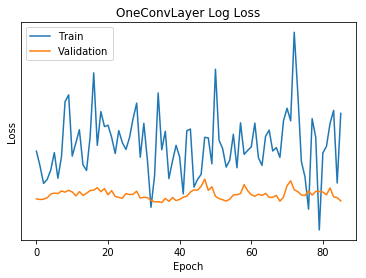

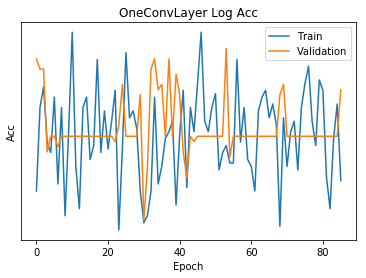

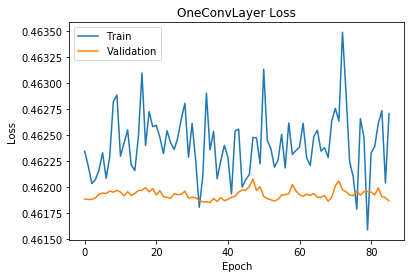

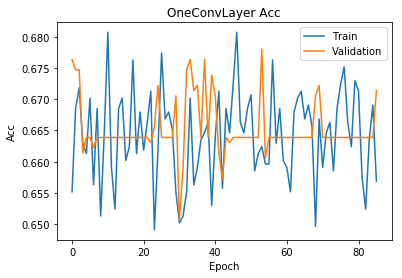

Confusion matrix, without normalization
[[403   0]
 [393 403]]
accuracy score:  0.672226855713
0.753575570158 For the label #0


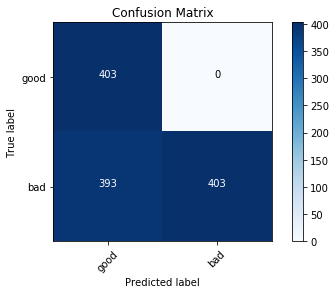

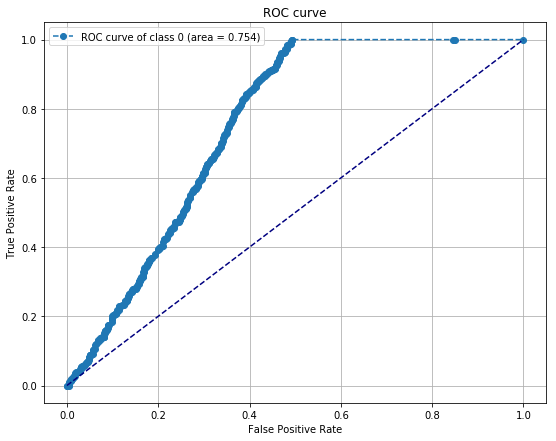

0.753578687482 For the label #1


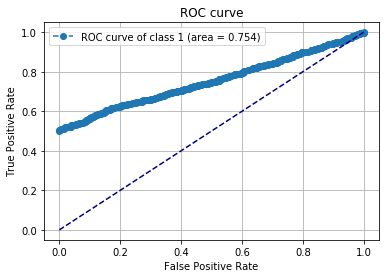

-----------------------------------------------------
TwoConvLayer
Epoch 00089: early stopping


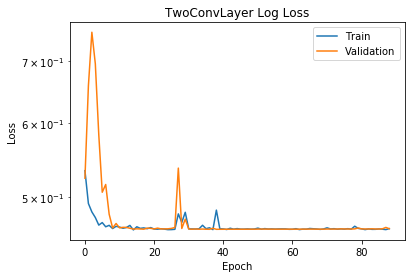

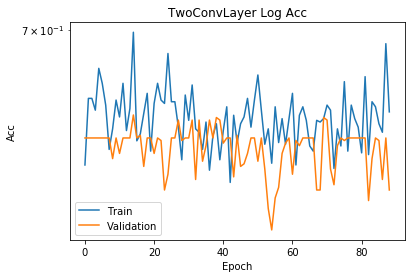

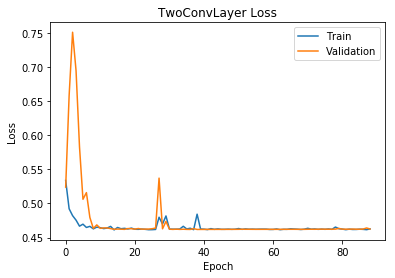

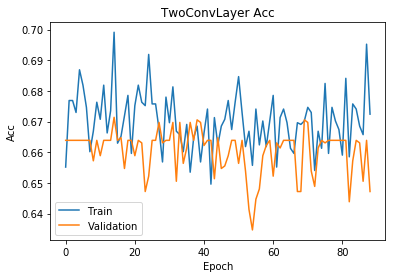

Confusion matrix, without normalization
[[403   0]
 [395 401]]
accuracy score:  0.670558798999
0.750285235109 For the label #0


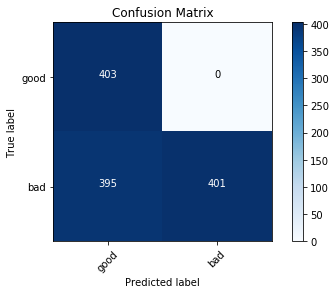

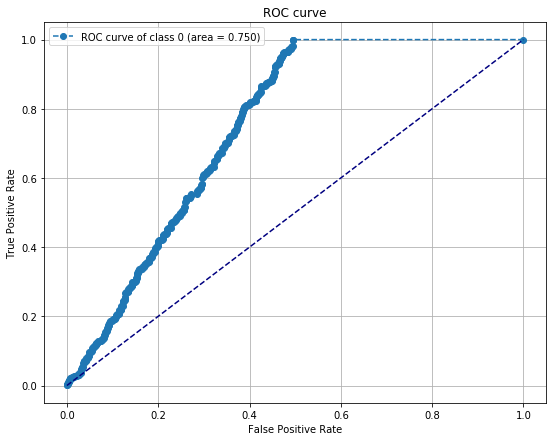

0.750283676447 For the label #1


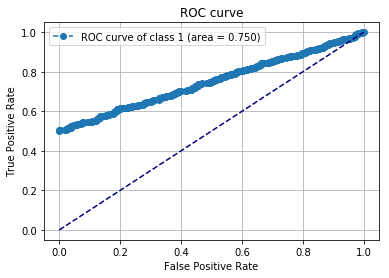

-----------------------------------------------------
ThreeConvLayer
Epoch 00068: early stopping


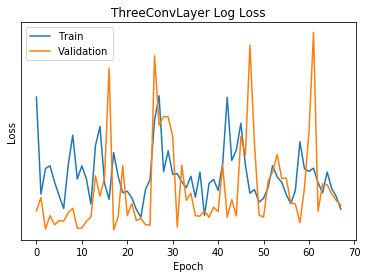

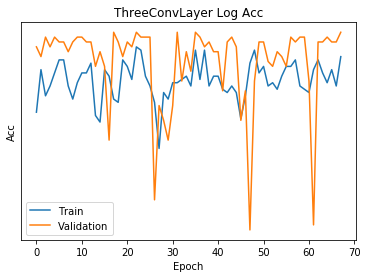

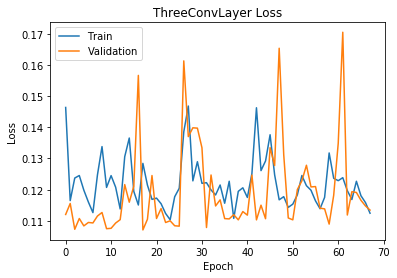

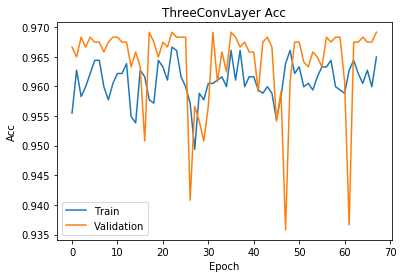

Confusion matrix, without normalization
[[403   0]
 [ 37 759]]
accuracy score:  0.969140950792
0.977068967667 For the label #0


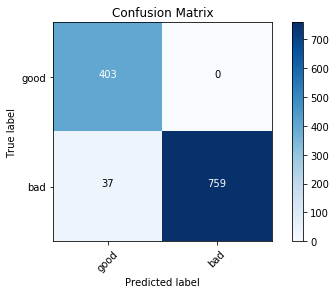

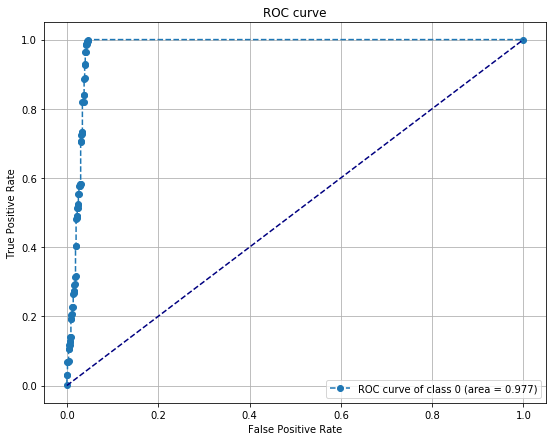

0.977068967667 For the label #1


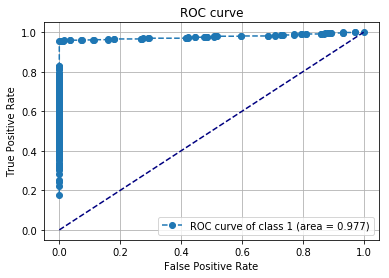

-----------------------------------------------------
OneDense
Epoch 00056: early stopping


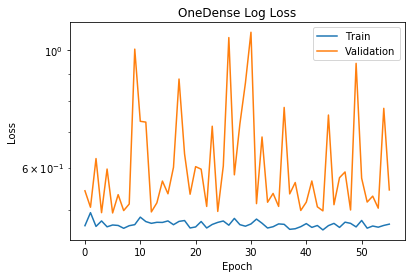

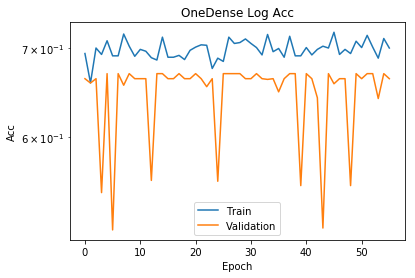

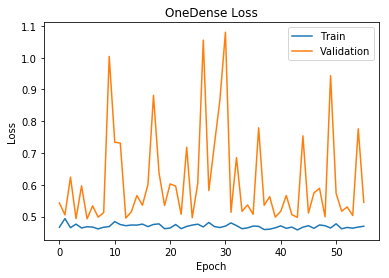

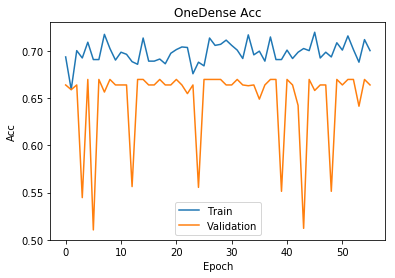

Confusion matrix, without normalization
[[121 282]
 [305 491]]
accuracy score:  0.510425354462
0.601440826964 For the label #0


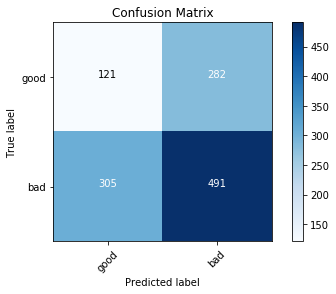

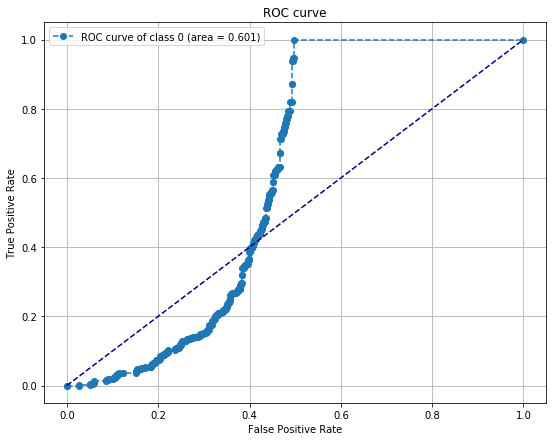

0.601440826964 For the label #1


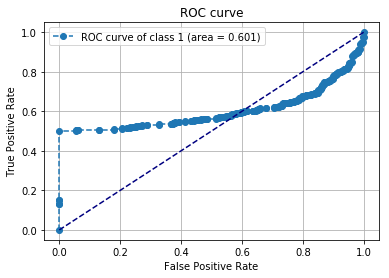

-----------------------------------------------------
TwoDense
Epoch 00074: early stopping


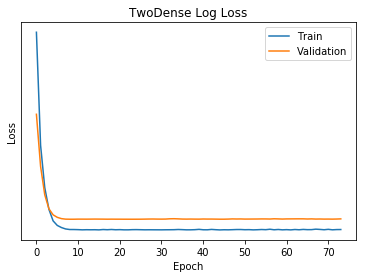

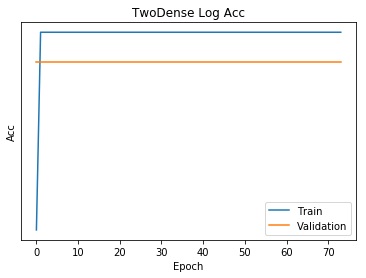

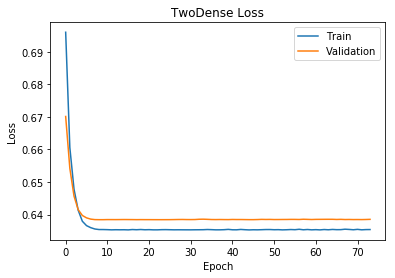

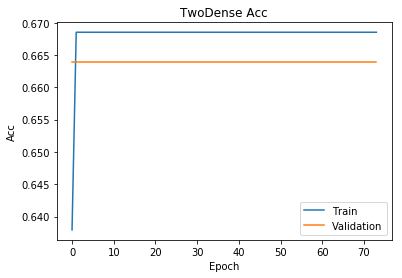

Confusion matrix, without normalization
[[  0 403]
 [  0 796]]
accuracy score:  0.663886572143
0.500628140704 For the label #0


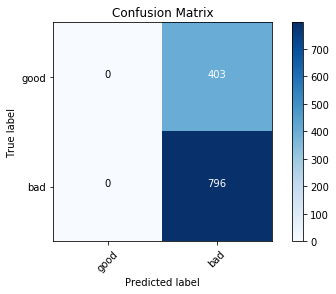

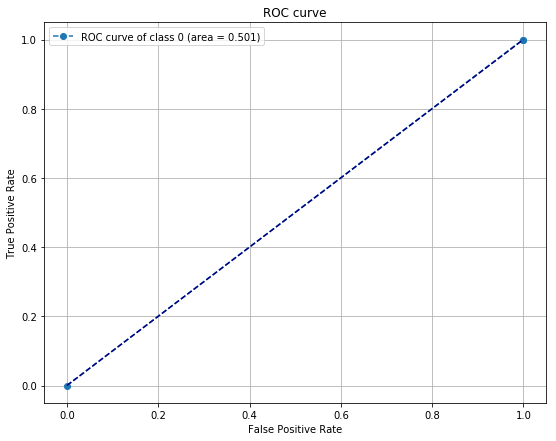

0.500628140704 For the label #1


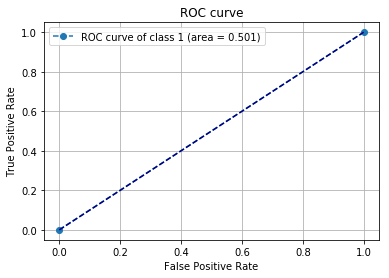

In [19]:
modelAcc = []
for i in range(len(Models)):
    checkpointer = ModelCheckpoint(filepath='best_nbmodel_good_bad.hdf5', verbose=0, save_best_only=True)
    earlystop= EarlyStopping(monitor='val_loss', min_delta=0, patience=50, verbose=1, mode='auto')
    print '-----------------------------------------------------'
    print ModelNames[i]
    history = Models[i].fit(Xtrain,ytrain,epochs=200
                    ,verbose=0
                    ,validation_data=(Xtest,ytest)
                    ,shuffle=True
                    ,callbacks=[checkpointer,earlystop])
    
    u.plot_loss(history, '{} {}'.format(ModelNames[i], 'Log Loss'),"log")
    u.plot_acc(history, '{} {}'.format(ModelNames[i], 'Log Acc'),"log")

    u.plot_loss(history, '{} {}'.format(ModelNames[i], 'Loss'),"linear")
    u.plot_acc(history, '{} {}'.format(ModelNames[i], 'Acc'),"linear")
    
    best_model= load_model('best_nbmodel_good_bad.hdf5',compile=False)
    
    ypred=best_model.predict(Xtest)
    ypredproba=best_model.predict_proba(Xtest)
    #it's preferable to use .predict_classes because .predict might give probabilities 
    #and not the label's in the case of multiclass
    ypredclass=best_model.predict_classes(Xtest)

    ypredclass=np.reshape(ypredclass,(ypredclass.shape[0],1))
    #use argmax(1) to give the position of max value in a categorical variable like ytest
    #it's basically a .predict_classes for ytest
    ytestclass= ytest.argmax(1)
    ytestclass=np.reshape(ytestclass,(ytestclass.shape[0],1))
    
    # from categorial to lable indexing
    confusion= metrics.confusion_matrix(ytestclass,ypredclass)

    plotlabels=['good','bad']
    u.plot_confusion_matrix(confusion,plotlabels,title='Confusion Matrix')
    modelAcc.append(metrics.accuracy_score(ytestclass,ypredclass))
    print 'accuracy score: ', metrics.accuracy_score(ytestclass,ypredclass)
    
    plt.figure(figsize=(9,7))
    plt.show
    
    for i in range(ypredproba.shape[1]):
        fpr,tpr,thresholds= roc_curve(ytestclass,ypredproba[:,i],pos_label=i)
        roc_auc = auc(fpr, tpr)
        
        print roc_auc,'For the label #{0}'.format(i)

        plt.plot(fpr,tpr, linestyle='dashed'
                 ,label='ROC curve of class {0} (area = {1:0.3f})' .format(i,roc_auc) ,marker='o')#% roc_auc, color='green'markerfacecolor='blue' ,markersize=4,
        plt.plot([0, 1], [0, 1], color='navy', linestyle='--') 
        plt.title('ROC curve')
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.legend()
        plt.grid(True)
        plt.show()

-----------------------------------------------------
OneConvLayer
Epoch 00051: early stopping


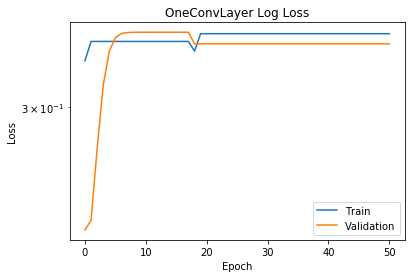

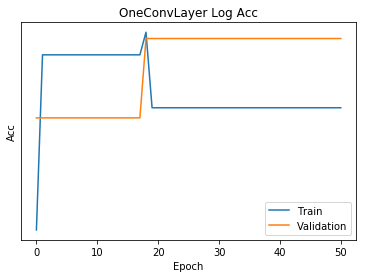

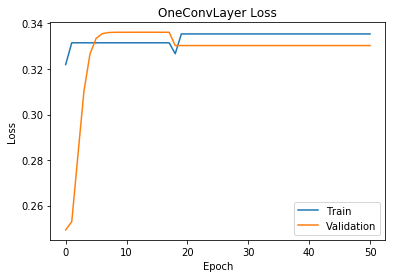

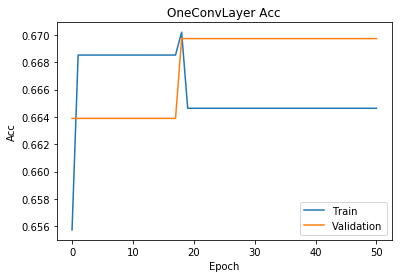

Confusion matrix, without normalization
[[403   0]
 [114 682]]
accuracy score:  0.904920767306
0.95297984962 For the label #0


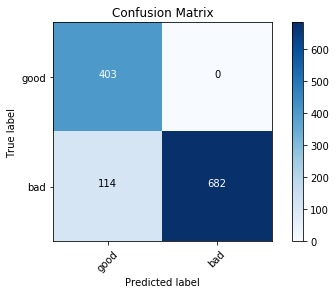

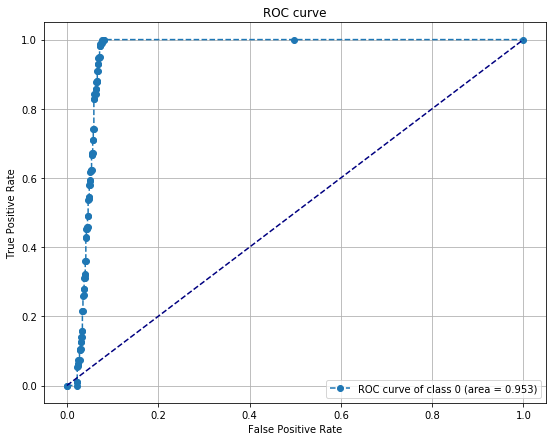

0.95297984962 For the label #1


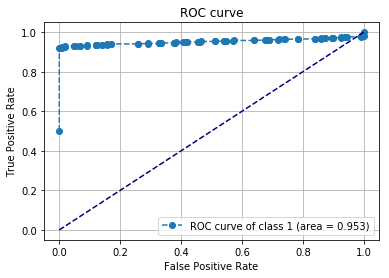

-----------------------------------------------------
TwoConvLayer
Epoch 00083: early stopping


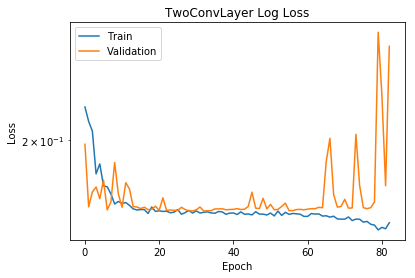

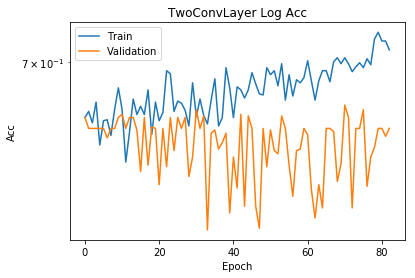

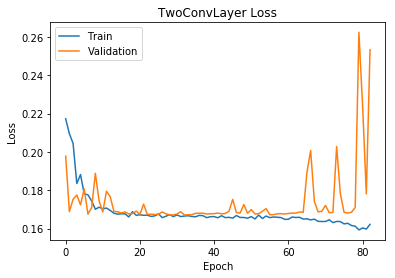

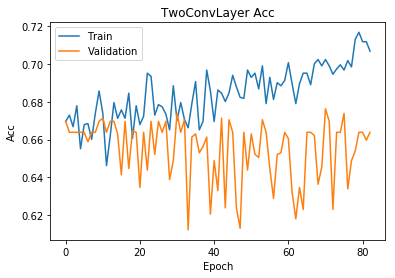

Confusion matrix, without normalization
[[342  61]
 [280 516]]
accuracy score:  0.715596330275
0.779228025986 For the label #0


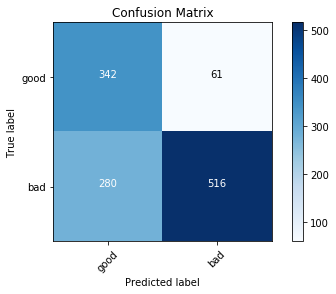

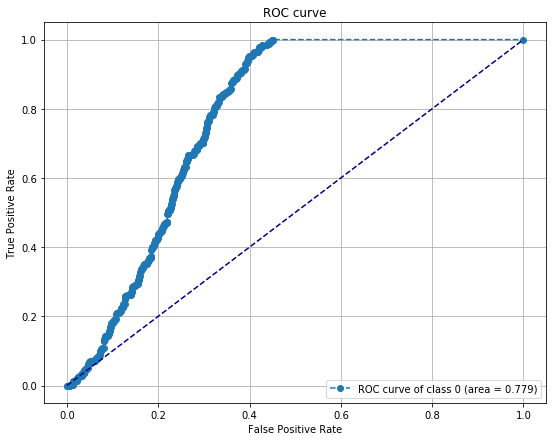

0.779228025986 For the label #1


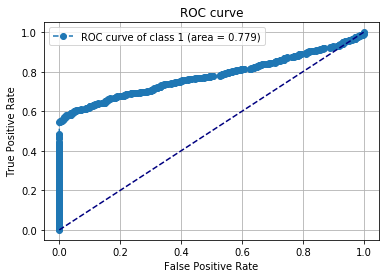

-----------------------------------------------------
ThreeConvLayer


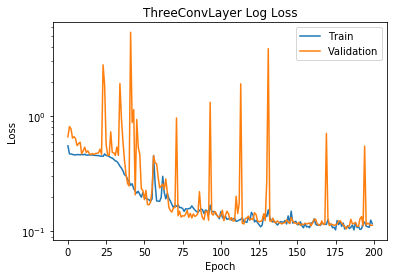

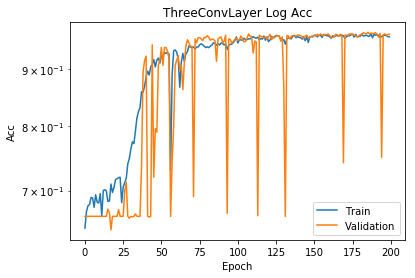

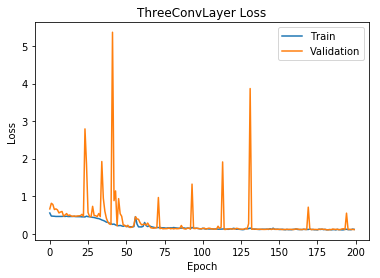

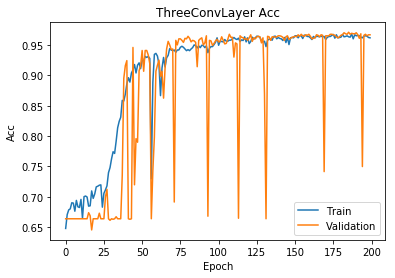

Confusion matrix, without normalization
[[ 44 359]
 [ 37 759]]
accuracy score:  0.669724770642
0.772742434256 For the label #0


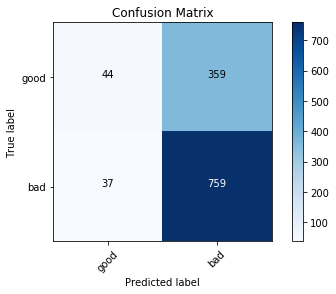

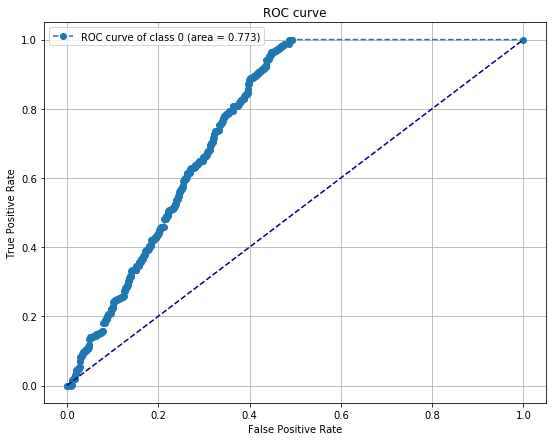

0.772740875594 For the label #1


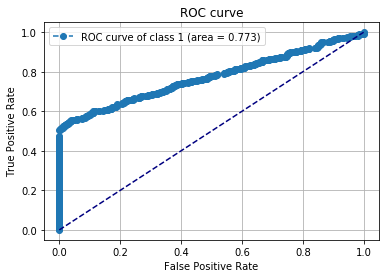

-----------------------------------------------------
OneDense


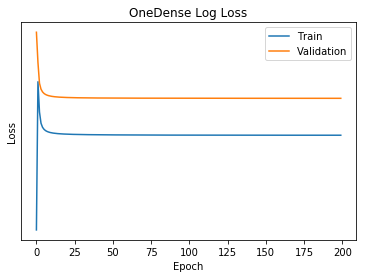

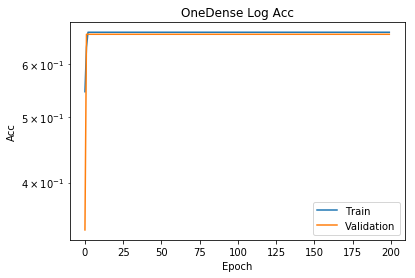

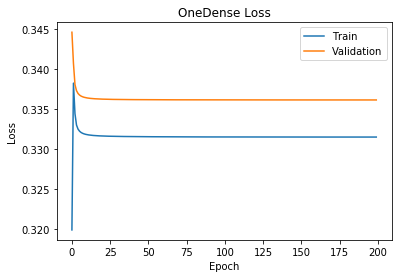

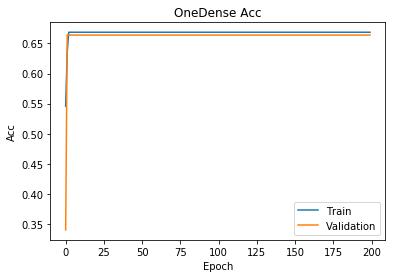

Confusion matrix, without normalization
[[  0 403]
 [  0 796]]
accuracy score:  0.663886572143
0.234163996159 For the label #0


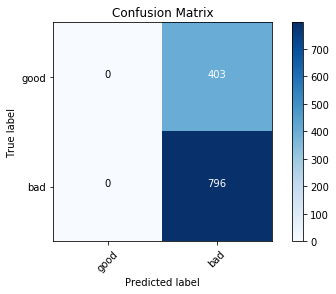

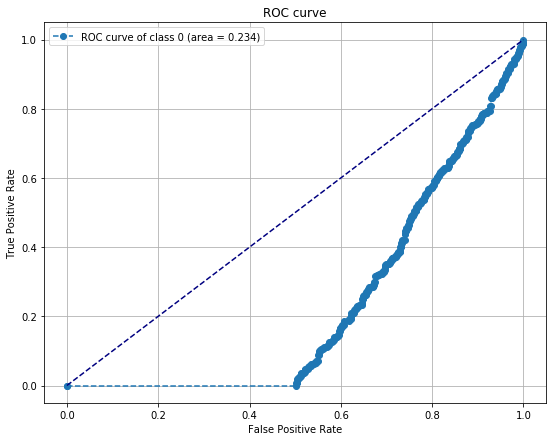

0.248743718593 For the label #1


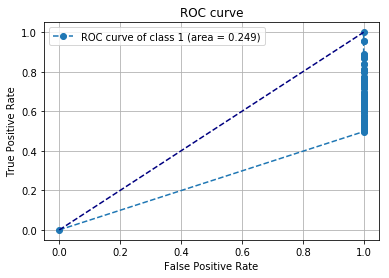

-----------------------------------------------------
TwoDense
Epoch 00053: early stopping


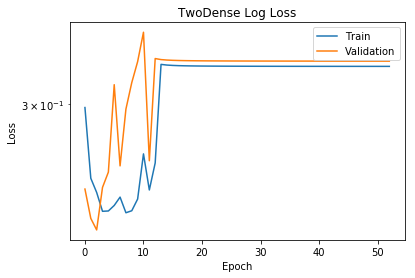

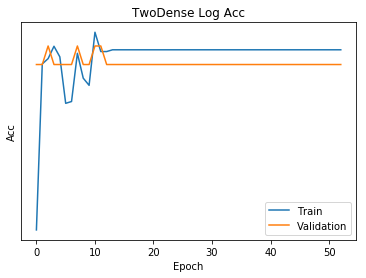

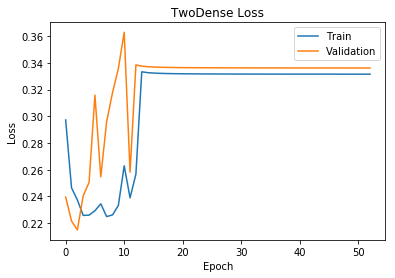

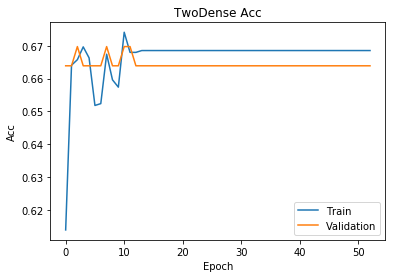

Confusion matrix, without normalization
[[403   0]
 [396 400]]
accuracy score:  0.669724770642
0.75796943776 For the label #0


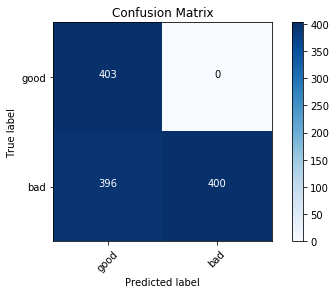

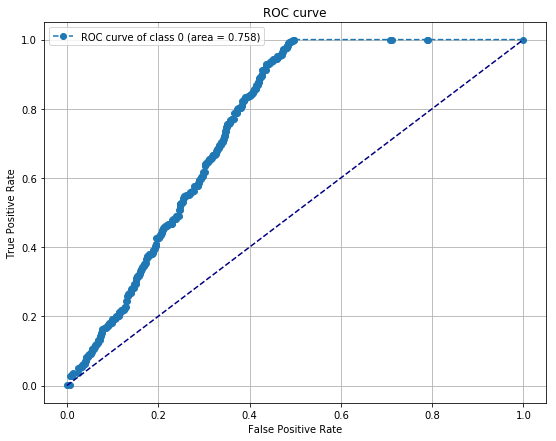

0.75796943776 For the label #1


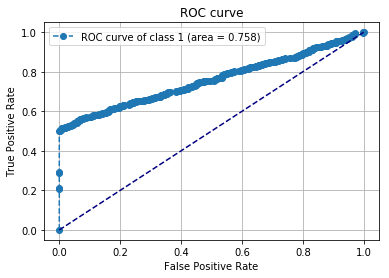

In [33]:
### Run again changing loss to mean squared error in all except threeConvLayer
modelAcc1 = []
for i in range(len(Models)):
    checkpointer = ModelCheckpoint(filepath='best_nbmodel_good_bad.hdf5', verbose=0, save_best_only=True)
    earlystop= EarlyStopping(monitor='val_loss', min_delta=0, patience=50, verbose=1, mode='auto')
    print '-----------------------------------------------------'
    print ModelNames[i]
    history = Models[i].fit(Xtrain,ytrain,epochs=200
                    ,verbose=0
                    ,validation_data=(Xtest,ytest)
                    ,shuffle=True
                    ,callbacks=[checkpointer,earlystop])
    
    u.plot_loss(history, '{} {}'.format(ModelNames[i], 'Log Loss'),"log")
    u.plot_acc(history, '{} {}'.format(ModelNames[i], 'Log Acc'),"log")

    u.plot_loss(history, '{} {}'.format(ModelNames[i], 'Loss'),"linear")
    u.plot_acc(history, '{} {}'.format(ModelNames[i], 'Acc'),"linear")
    
    best_model= load_model('best_nbmodel_good_bad.hdf5',compile=False)
    
    ypred=best_model.predict(Xtest)
    ypredproba=best_model.predict_proba(Xtest)
    #it's preferable to use .predict_classes because .predict might give probabilities 
    #and not the label's in the case of multiclass
    ypredclass=best_model.predict_classes(Xtest)

    ypredclass=np.reshape(ypredclass,(ypredclass.shape[0],1))
    #use argmax(1) to give the position of max value in a categorical variable like ytest
    #it's basically a .predict_classes for ytest
    ytestclass= ytest.argmax(1)
    ytestclass=np.reshape(ytestclass,(ytestclass.shape[0],1))
    
    # from categorial to lable indexing
    confusion= metrics.confusion_matrix(ytestclass,ypredclass)

    plotlabels=['good','bad']
    u.plot_confusion_matrix(confusion,plotlabels,title='Confusion Matrix')
    modelAcc.append(metrics.accuracy_score(ytestclass,ypredclass))
    print 'accuracy score: ', metrics.accuracy_score(ytestclass,ypredclass)
    
    plt.figure(figsize=(9,7))
    plt.show
    
    for i in range(ypredproba.shape[1]):
        fpr,tpr,thresholds= roc_curve(ytestclass,ypredproba[:,i],pos_label=i)
        roc_auc = auc(fpr, tpr)
        
        print roc_auc,'For the label #{0}'.format(i)

        plt.plot(fpr,tpr, linestyle='dashed'
                 ,label='ROC curve of class {0} (area = {1:0.3f})' .format(i,roc_auc) ,marker='o')#% roc_auc, color='green'markerfacecolor='blue' ,markersize=4,
        plt.plot([0, 1], [0, 1], color='navy', linestyle='--') 
        plt.title('ROC curve')
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.legend()
        plt.grid(True)
        plt.show()